In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# Comparison with synthetic data

We shall compare our comparison methods (ahem) with a real geographic region (Chicago North Side, for variety) three models (detailed below, all are (in)homogeneous Poisson processes) and with 3 choices of "rate", governing the expected number of "actual" events to test against.  Our "predictions" will be the same as the models, to see how well a model fits data from a different model.

### Model 1

[Complete Spatial Random-ness](https://en.wikipedia.org/wiki/Complete_spatial_randomness).

### Model 2

A simple inhomogeneous poisson process with intensity varying linearly in the x direction across the geometry

### Model 3


## Procedure

Everything will happen on a grid of size of 150m

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import descartes
import numpy as np
import pandas as pd
import os, datetime

import open_cp.sources.chicago
import open_cp.geometry
import open_cp.plot
import open_cp.predictors
import open_cp.evaluation
import open_cp.kernels

# The geometry and grid

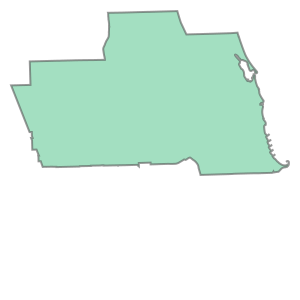

In [3]:
#open_cp.sources.chicago.set_data_directory(os.path.join("..", "..", "..", "..", "Data"))
open_cp.sources.chicago.set_data_directory(os.path.join("/media", "disk", "Data"))
northside = open_cp.sources.chicago.get_side("North")
northside

In [4]:
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)
grid

MaskedGrid(offset=(349500,582300), size=150x150, mask region=65x39)

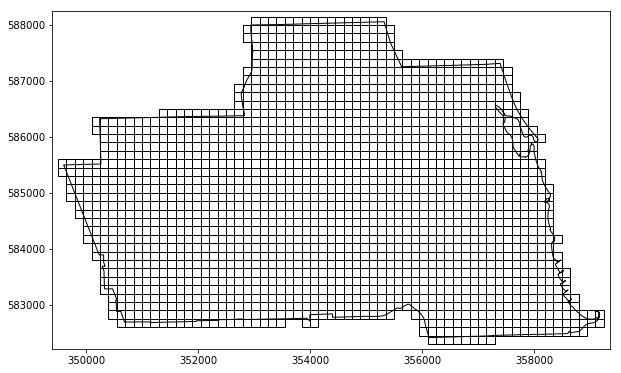

In [5]:
p = open_cp.plot.patches_from_grid(grid)

fig, ax = plt.subplots(figsize=(10,10))
ax.add_collection(matplotlib.collections.PatchCollection(p, facecolor="none", edgecolor="black"))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))

xmin, ymin, xmax, ymax = northside.bounds
d = 200
ax.set(xlim=[xmin-d,xmax+d], ylim=[ymin-d, ymax+d])
ax.set_aspect(1)
None

# The models

In [6]:
class BaseModel():
    def __init__(self, grid):
        self._grid = grid
    
    def prob(self, x, y):
        want, pt = self._in_grid(x, y)
        if want:
            return self._probs[pt[1], pt[0]]
        return 0.0
        
    def max_prob(self):
        return np.max(np.ma.array(self._probs, mask=self._grid.mask))
        
    @property
    def grid(self):
        return self._grid
        
    def to_grid_coords(self, x, y):
        pt = np.asarray([x,y]) - [self.grid.xoffset, self.grid.yoffset]
        pt = np.floor_divide(pt, [self.grid.xsize, self.grid.ysize]).astype(np.int)
        return pt

    def in_grid(self, x, y):
        pt = self.to_grid_coords(x, y)
        if np.all((pt >= [0, 0]) & (pt < [self.grid.xextent, self.grid.yextent])):
            return self.grid.is_valid(*pt)
        return False
    
    def to_prediction(self):
        mat = np.array(self._probs)
        pred = open_cp.predictors.GridPredictionArray(self.grid.xsize, self.grid.ysize,
                                        mat, self.grid.xoffset, self.grid.yoffset)
        pred.mask_with(self.grid)
        return pred
    
    def map_to_grid(self, x, y):
        """Map a point in :math:`[0,1]^2` to the bounding box of the grid"""
        pt = np.asarray([x,y])
        pt = pt * [self._grid.xsize * self._grid.xextent, self._grid.ysize * self._grid.yextent]
        return pt + [self._grid.xoffset, self._grid.yoffset]
    
    def _in_grid(self, x, y):
        pt = self.to_grid_coords(x, y)
        if np.all((pt >= [0, 0]) & (pt < [self.grid.xextent, self.grid.yextent])):
            return self.grid.is_valid(*pt), pt
        return False, pt
    
    def _set_probs(self, probs):
        probs = self.grid.mask_matrix(probs)
        self._probs = probs / np.sum(probs)

    
b = BaseModel(grid)
assert not b.in_grid(0,0)
assert b.in_grid(354000, 584000)
assert np.all(b.to_grid_coords(grid.xoffset, grid.yoffset) == [0,0])

In [7]:
def sample(model, size):
    out = []
    renorm = model.max_prob()
    while len(out) < size:
        pt = model.map_to_grid(*np.random.random(2))
        if model.in_grid(*pt):
            if model.prob(*pt) > np.random.random() * renorm:
                out.append(pt)
    return np.asarray(out)

def sample_to_timed_points(model, size):
    t = [datetime.datetime(2017,1,1)] * size
    pts = sample(model, size)
    assert pts.shape == (size, 2)
    return open_cp.data.TimedPoints.from_coords(t, *pts.T)

In [8]:
class Model1(BaseModel):
    def __init__(self, grid):
        super().__init__(grid)
        probs = np.zeros((grid.yextent, grid.xextent)) + 1
        self._set_probs(probs)
        
    def to_randomised_prediction(self):
        mat = np.array(self._probs)
        mat += np.random.random(mat.shape) * 1e-7
        pred = open_cp.predictors.GridPredictionArray(self.grid.xsize, self.grid.ysize,
                                        mat, self.grid.xoffset, self.grid.yoffset)
        pred.mask_with(self.grid)
        pred = pred.renormalise()
        return pred
    
    def __str__(self):
        return "Model1"
        
m = Model1(grid)
assert m.prob(0, 10) == 0.0
assert m.prob(354000, 584000) == 1 / np.sum(~grid.mask)

In [9]:
class Model2(BaseModel):
    def __init__(self, grid):
        super().__init__(grid)
        probs = np.linspace(0, 1, grid.xextent)
        probs = probs[None,:] + np.zeros(grid.yextent)[:,None]
        self._set_probs(probs)
        
    def __str__(self):
        return "Model2"

In [10]:
class Model3(BaseModel):
    def __init__(self, grid):
        super().__init__(grid)
        probs = np.empty((grid.yextent, grid.xextent))
        for x in range(grid.xextent):
            for y in range(grid.yextent):
                probs[y,x] = self.cts_prob((x+0.5) / grid.xextent, (y+0.5) / grid.yextent)
        self._set_probs(probs)
        
    def cts_prob(self, x, y):
        return 2 * np.exp(-(x-y)**2 * 20) + y
    
    def __str__(self):
        return "Model3"    

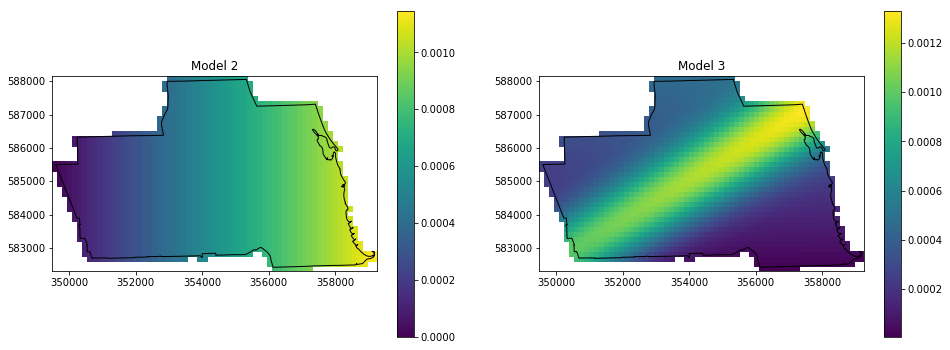

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for ax, Model in zip(axes, [Model2, Model3]):
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    m = Model(grid)
    pred = m.to_prediction()
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix)
    plt.colorbar(m, ax=ax)

axes[0].set_title("Model 2")
axes[1].set_title("Model 3")
None

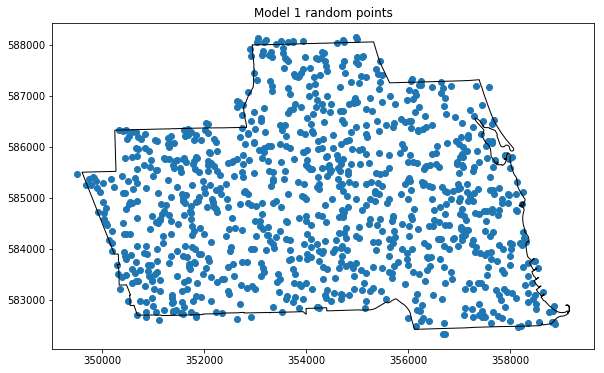

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = Model1(grid)
pt = sample(m, 1000)
ax.scatter(*pt.T)
ax.set_title("Model 1 random points")
None

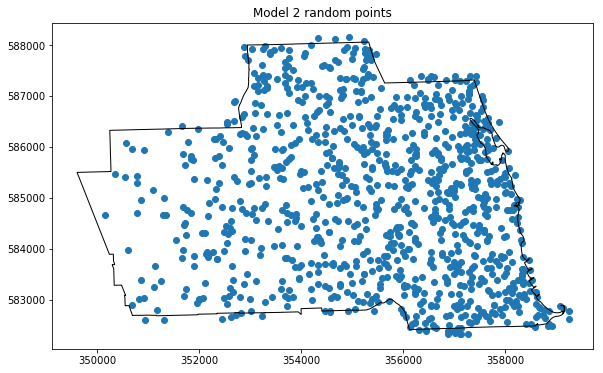

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = Model2(grid)
pt = sample(m, 1000)
ax.scatter(*pt.T)
ax.set_title("Model 2 random points")
None

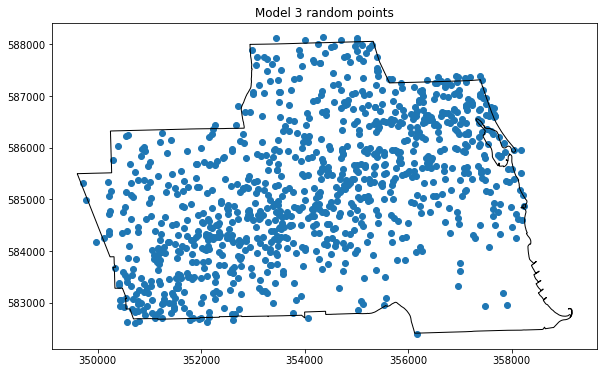

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = Model3(grid)
pt = sample(m, 1000)
ax.scatter(*pt.T)
ax.set_title("Model 3 random points")
None

# Run evaluations

In [15]:
def generate_data_preds(num_trials=1000, base_intensity=10):
    for SourceModel in [Model1, Model2, Model3]:
        source_model = SourceModel(grid)
        for PredModel in [Model1, Model2, Model3]:
            pred_model = PredModel(grid)
            for trial in range(num_trials):
                num_pts = np.random.poisson(base_intensity)
                if num_pts == 0:
                    continue
                tps = sample_to_timed_points(source_model, num_pts)
                try:
                    pred = pred_model.to_randomised_prediction()
                except:
                    pred = pred_model.to_prediction()
                key = (str(source_model), str(pred_model))
                yield key, pred, tps

In [16]:
def plot_models(func):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
    labels = ["Model1", "Model2", "Model3"]
    for axe, k1 in zip(axes, labels):
        for ax, k2 in zip(axe, labels):
            ax.set_title("{}/{}".format(k1,k2))
            result = [data[k] for k in data if k[:2] == (k1, k2)]
            func(result, ax, (k1, k2))
            None

    fig.tight_layout()

## Hit rate

- As `Model1` assigns the same probability to all grid cells, for computing the hit rate, we add a very small random perturbation.

In [17]:
data = { key+(i,) : open_cp.evaluation.inverse_hit_rates(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

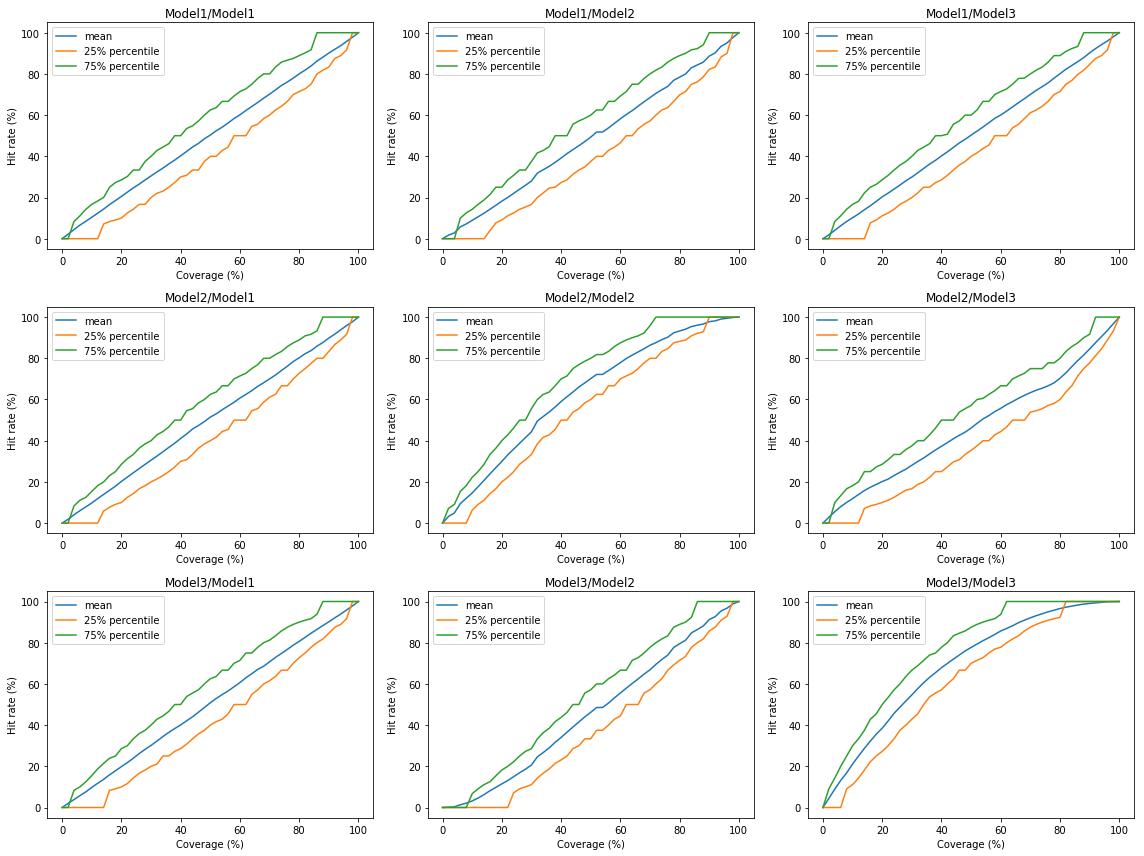

In [18]:
coverages = list(range(0,102,2))

def hitrate_inverse_to_hitrate(inv_dict, coverages):
    out = dict()
    for cov in coverages:
        choices = [k for k,v in inv_dict.items() if v <= cov]
        out[cov] = 0 if len(choices) == 0 else max(choices)
    return out

def plot_func(result, ax, key):
    by_cov = {cov : [] for cov in coverages}
    for row in result:
        out = hitrate_inverse_to_hitrate(row, coverages)
        for c in out:
            by_cov[c].append(out[c])
        #x = list(out)
        #y = [out[t] for t in x]
        #ax.scatter(x, y, linewidth=1, color="black", alpha=0.01, marker="x")
    frame = pd.DataFrame(by_cov).describe().T
    ax.plot(frame["mean"], label="mean")
    ax.plot(frame["25%"], label="25% percentile")
    ax.plot(frame["75%"], label="75% percentile")
    ax.set(xlabel="Coverage (%)", ylabel="Hit rate (%)")
    ax.set(xlim=[-5,105], ylim=[-5,105])
    ax.legend()
    
plot_models(plot_func)

## Likelihood

In [19]:
data = { key+(i,) : open_cp.evaluation.likelihood(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

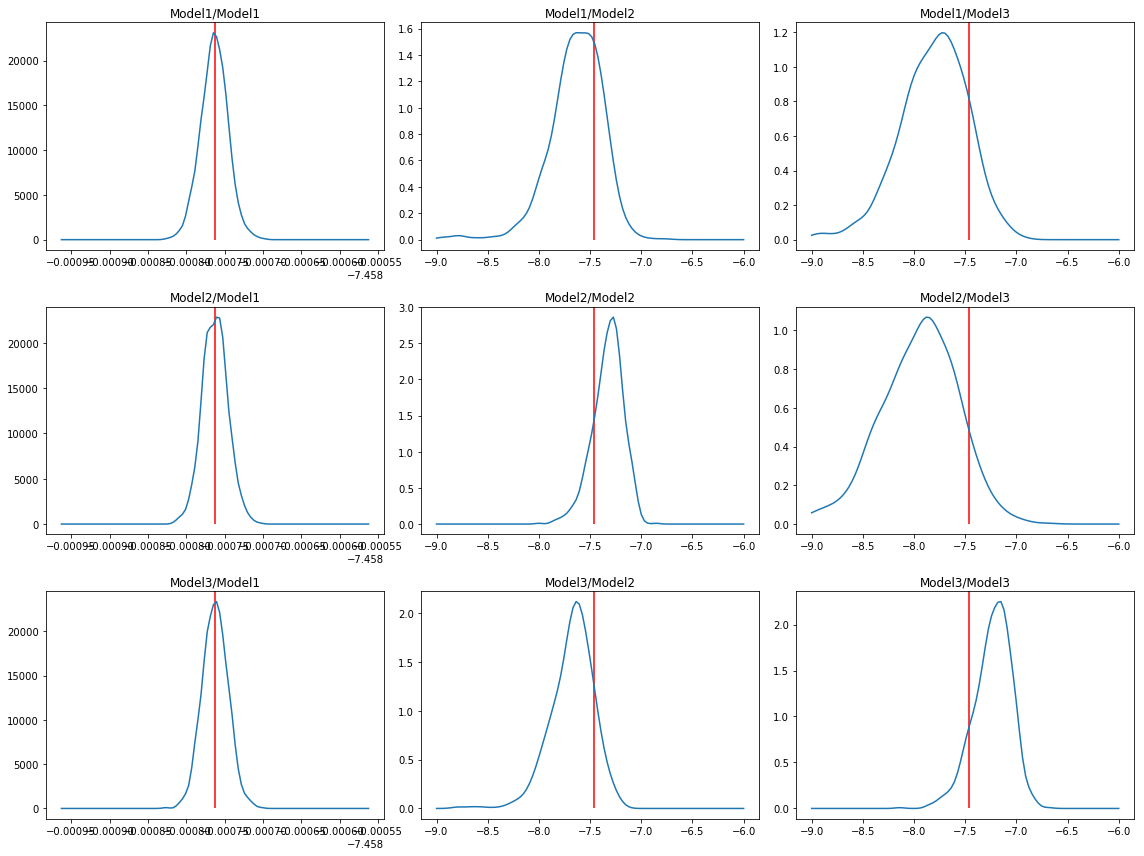

In [20]:
import scipy.stats

def plot_func(result, ax, key):
    kernel = scipy.stats.kde.gaussian_kde(result)
    xx = -np.log(np.sum(~grid.mask))
    if key[1] == "Model1":
        d = 0.0002
        x = np.linspace(xx - d, xx + d, 100)
    else:
        x = np.linspace(-9, -6, 100)
    ax.plot(x, kernel(x))
    line = [[xx,0], [xx,100000]]
    ax.add_collection(matplotlib.collections.LineCollection([line], color="red"))
    
plot_models(plot_func)

## KDE

In [21]:
m = Model3(grid)
pt = sample(m, 100)
kernel = open_cp.kernels.GaussianEdgeCorrectGrid(pt.T, grid)
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
pred = pred.renormalise()

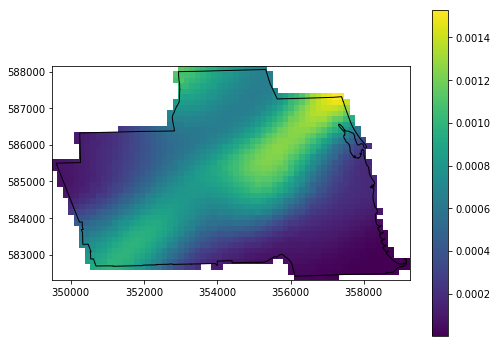

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix)
plt.colorbar(m, ax=ax)

In [ ]:
def score_kde(pred, tps):
    points = np.asarray([tps.xcoords, tps.ycoords])
    kernel = open_cp.kernels.GaussianEdgeCorrectGrid(points, grid)
    kde_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
    kde_pred = kde_pred.renormalise()
    
    return np.sum((pred.intensity_matrix - kde_pred.intensity_matrix)**2) * grid.xsize * grid.ysize

In [ ]:
data = { key+(i,) : score_kde(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds())
        if tps.number_data_points > 2
       }

In [ ]:
def plot_func(result, ax, key):
    bins = np.linspace(0, 70, 20)
    ax.hist(result, bins)
    
plot_models(plot_func)

In [ ]:
m = Model3(grid)
pt = sample(m, 100)
kernel = open_cp.kernels.GaussianEdgeCorrectGrid(pt.T, grid)
kernel.covariance_matrix = [[1,0],[0,1]]
kernel.bandwidth = 100
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
pred = pred.renormalise()

fig, ax = plt.subplots(figsize=(8,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix)
plt.colorbar(m, ax=ax)

In [ ]:
def score_kde_fixed(pred, tps):
    points = np.asarray([tps.xcoords, tps.ycoords])
    kernel = open_cp.kernels.GaussianEdgeCorrectGrid(points, grid)
    kernel.covariance_matrix = [[1,0],[0,1]]
    kernel.bandwidth = 100
    kde_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
    kde_pred = kde_pred.renormalise()
    
    return np.sum((pred.intensity_matrix - kde_pred.intensity_matrix)**2) * grid.xsize * grid.ysize

In [ ]:
data = { key+(i,) : score_kde_fixed(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds())
        if tps.number_data_points > 2
       }

In [ ]:
def plot_func(result, ax, key):
    bins = np.linspace(0, 1300, 20)
    ax.hist(result, bins)
    
plot_models(plot_func)

# Brier score

In [ ]:
data = { key+(i,) : open_cp.evaluation.brier_score(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

In [ ]:
def plot_func(result, ax, key):
    brier = [row[0] for row in result]
    bins = np.linspace(0, 1e-8, 20)
    ax.hist(brier, bins)
    
plot_models(plot_func)

In [ ]:
def plot_func(result, ax, key):
    skill = [row[1] for row in result]
    bins = np.linspace(0, 0.03, 20)
    ax.hist(skill, bins)
    
plot_models(plot_func)

### Multiscale Brier

In [ ]:
def multiscale_brier(pred, tps):
    maxsize = min(pred.xextent, pred.yextent)
    return {s : open_cp.evaluation.multiscale_brier_score(pred, tps,s) for s in range(1, maxsize+1)}

data = { key+(i,) : multiscale_brier(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds(num_trials=50)) }

In [ ]:
def plot_func(result, ax, key):
    for data in result:
        x = list(data)
        # Score
        y = [data[t][0] for t in x]
        ax.plot(x, np.log(y), color="black", linewidth=1, alpha=0.5)
        ax.set(ylim=[-27,-17])
    
plot_models(plot_func)

In [ ]:
def plot_func(result, ax, key):
    for data in result:
        x = list(data)
        # Skill
        y = [data[t][1] for t in x]
        ax.plot(x, y, color="black", linewidth=1, alpha=0.5)
        ax.set(ylim=[-0.1, 1.1])
    
plot_models(plot_func)

## KL Skill

In [ ]:
data = { key+(i,) : open_cp.evaluation.kl_score(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

In [ ]:
def plot_func(result, ax, key):
    bins = np.linspace(1e-7, 2e-7, 20)
    ax.hist(result, bins)

plot_models(plot_func)

### Multiscale KL Score

In [ ]:
def multiscale_kl(pred, tps):
    maxsize = min(pred.xextent, pred.yextent)
    return {s : open_cp.evaluation.multiscale_kl_score(pred, tps,s) for s in range(1, maxsize+1)}

data = { key+(i,) : multiscale_kl(pred, tps)
        for i, (key, pred, tps) in enumerate(generate_data_preds(num_trials=50)) }

In [ ]:
def plot_func(result, ax, key):
    for data in result:
        x = list(data)
        y = [data[t] for t in x]
        ax.plot(x, np.log(y), color="black", linewidth=1, alpha=0.5)
        #ax.set(ylim=[-27,-17])
    
plot_models(plot_func)

## Bayesian

In [ ]:
import importlib
importlib.reload(open_cp.evaluation)

In [ ]:
data = { key+(i,) : open_cp.evaluation.bayesian_dirichlet_prior(pred, tps, bias=1)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

In [ ]:
def plot_func(result, ax, key):
    bins = np.linspace(10, 140, 20)
    ax.hist(result, bins)
    ax.set(ylim=[0,170])
    
plot_models(plot_func)